In [1]:
import jupyterthemes
#!jt -t oceans16 -cellw 100% -N -T
!jt -t gruvboxl -cellw 100% -T -N -ofs 12 -fs 12

!jt -l
#!jt -r

Available Themes: 
   chesterish
   grade3
   gruvboxd
   gruvboxl
   monokai
   oceans16
   onedork
   solarizedd
   solarizedl


Общий вид мультипликативной модели выглядит так:  
$Y = T\bullet S\bullet E$

Процесс построения модели включает в себя следующие шаги:  
1. Выравнивание исходного ряда методом скользящей средней.
2. Расчет значений сезонной компоненты $S$.
3. Устранение сезонной компоненты из исходных уровней ряда и
получение выровненных данных ($T+E$) в аддитивной или ($T\bullet E$)
мультипликативной модели.
4. Аналитическое выравнивание уровней ($T+E$) или ($T\bullet E$) и расчет
значений T с использованием полученного уравнения тренда.
5. Расчет полученных по модели значений ($T+E$) или ($T\bullet E$).
6. Расчет абсолютных и/или относительных ошибок

## Импорт библиотек

In [2]:
import pandas as pd
import sys
if sys.version_info[0] < 3: 
    from StringIO import StringIO
else:
    from io import StringIO
import numpy as np

## Загрузка данных

<Axes: xlabel='№ квартала, t'>

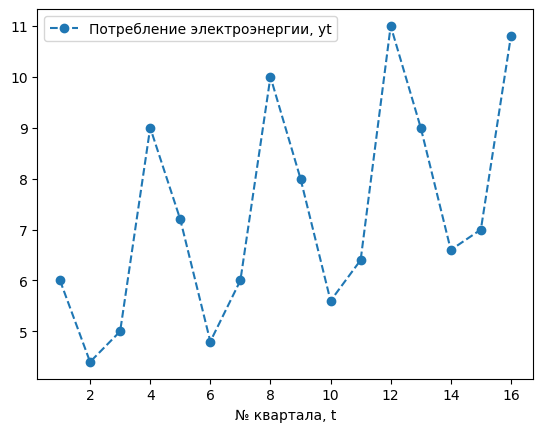

In [3]:
data = StringIO('''№ квартала, t;Потребление электроэнергии, yt
1; 6
2; 4.4
3; 5
4; 9
5; 7.2
6; 4.8
7; 6
8; 10
9; 8
10; 5.6
11; 6.4
12; 11
13; 9
14; 6.6
15; 7
16; 10.8''')
df = pd.read_csv(data, sep=";").set_index('№ квартала, t')
df.plot(style='--o')

### 1. Проведем выравнивание исходных уравнений ряда методом скользящей средней

In [4]:
df['Скользящая средняя за 4 квартала'] = np.nan
for i in range(len(df) - 3):
    df[df.columns[1]].loc[i+3] = \
        df[df.columns[0]].loc[i+1:i+4].mean()

In [5]:
df['Центрированная cкользящая средняя'] = np.nan
for i in range(len(df) - 1):
    temp_data = df[df.columns[1]].loc[i+1:i+2] # текущее и предыдущее знач.
    if temp_data.isnull().any(): continue # если среди данных есть Nan
    df[df.columns[2]].loc[i+1] = temp_data.mean() # берем среднее по ним

In [6]:
df['Оценка сезонной компоненты'] = df[df.columns[0]] - df[df.columns[2]]
display(df)

,"Потребление электроэнергии, yt",Скользящая средняя за 4 квартала,Центрированная cкользящая средняя,Оценка сезонной компоненты
"№ квартала, t",,,,
1,6.0,NaN,NaN,NaN
2,4.4,NaN,NaN,NaN
3,5.0,6.10,6.250,-1.250
4,9.0,6.40,6.450,2.550
5,7.2,6.50,6.625,0.575
6,4.8,6.75,6.875,-2.075
7,6.0,7.00,7.100,-1.100
8,10.0,7.20,7.300,2.700
9,8.0,7.40,7.450,0.550


Результирующая таблица шага 1.

### 2. Расчет значений сезонной компоненты в аддитивной модели


сгрупируем по годам оценку сезонной компоненты

In [7]:
df['Год'] = (df.index + 3) // 4
df[df.columns[3:5]].groupby('Год').sum()
dataFrame = df.groupby(['Год'])\
    .agg({'Оценка сезонной компоненты': lambda arg: list(arg)})\
    ['Оценка сезонной компоненты'].apply(pd.Series)\
    .rename(columns={i: f'{i + 1} квартал' for i in range(4)})
dataFrame

,1 квартал,2 квартал,3 квартал,4 квартал
Год,,,,
1,NaN,NaN,-1.250,2.550
2,0.575,-2.075,-1.100,2.700
3,0.550,-2.025,-1.475,2.875
4,0.675,-1.775,NaN,NaN


In [8]:
dataFrame.index = \
    pd.MultiIndex.from_product([[''],[1,2,3,4]], names = ['Показатели', 'Год'])

In [9]:
dataFrame.loc[('Итого за i-тый квартал',''), :] = dataFrame.loc[''].sum()
dataFrame.loc[('Средняя оценка сезонной компоненты для i-го квартала',''), :] = \
    dataFrame.loc[''].mean()
dataFrame.loc[('Скорректированная сезонная компонента',''), :] = \
    dataFrame.loc[('Средняя оценка сезонной компоненты для i-го квартала','')] - \
    dataFrame.loc[('Средняя оценка сезонной компоненты для i-го квартала','')].mean()
dataFrame.loc[('Корректирующий коэффициет',
    dataFrame.loc[('Средняя оценка сезонной компоненты для i-го квартала','')].mean().round(3)
              ), :] = ''
dataFrame['Сумма'] = ''
for column in ['Средняя оценка сезонной компоненты для i-го квартала','Скорректированная сезонная компонента']:
    dataFrame.loc[(column,''), 'Сумма'] = \
        dataFrame.loc[(column,''),dataFrame.columns[0:-1]].sum()

In [10]:
round(dataFrame,3)

1 квартал 2 квартал   
Показатели                                         Год                         
                                                   1           NaN       NaN  \
                                                   2         0.575    -2.075   
                                                   3          0.55    -2.025   
                                                   4         0.675    -1.775   
Итого за i-тый квартал                                         1.8    -5.875   
Средняя оценка сезонной компоненты для i-го ква...             0.6 -1.958333   
Скорректированная сезонная компонента                      0.58125 -1.977083   
Корректирующий коэффициет                          0.019                       

                                                         3 квартал 4 квартал   
Показатели                                         Год                         
                                                   1         -1.25      2.55  \
                                                   2          -1.1       2.7   
                                                   3        -1.475     2.875   
                                                   4           NaN       NaN   
Итого за i-тый квартал                                      -3.825     8.125   
Средняя оценка сезонной компоненты для i-го ква...          -1.275  2.708333   
Скорректированная сезонная компонента                     -1.29375  2.689583   
Корректирующий коэффициет                          0.019                       

                                                          Сумма  
Показатели                                         Год           
                                                   1             
                                                   2             
                                                   3             
                                                   4             
Итого за i-тый квартал                                           
Средняя оценка сезонной компоненты для i-го ква...        0.075  
Скорректированная сезонная компонента                       0.0  
Корректирующий коэффициет                          0.019

### Расчет выровнненых значений T и ошибок Е в аддитивной модели
Элиминируем влияние сезонной компоненты:  

Вычитем значение сезонной компоненты из каждого уровня исходного временного ряда. Получим величины $T + E = Y + S$. Эти значения рассчитываются за каждый момент времени и содержат только тенденцию и случайную компоненту.

In [11]:
v = list(dataFrame.loc[('Скорректированная сезонная компонента',''),dataFrame.columns[0:-1]])

In [12]:
df3= df.drop(columns=df.columns[1:])

df3.loc[df.index[-1] + 1] = np.nan
df3.loc[df.index[-1] + 2] = np.nan
df3['Скорректировання сезонная компонента, Si'] = v * 4 + [v[0]] + [v[1]]

df3['T+E=Y+S'] = df3[df.columns[0]] - df3['Скорректировання сезонная компонента, Si'] 

least_sq_coefs = np.polyfit(df3['T+E=Y+S'].iloc[0:16].index, df3['T+E=Y+S'].iloc[0:16], deg=1)
least_sq_func = np.poly1d(least_sq_coefs)

df3['T'] = least_sq_func(list(df3['T+E=Y+S'].index))
df3['T+S'] = df3['T'] + df3['Скорректировання сезонная компонента, Si']
df3['E=yt-(T+S)'] = df3[df.columns[0]] - df3['T+S']
df3['$E^2$'] = df3['E=yt-(T+S)'].pow(2)

#df3.loc['Среднее:',[df.columns[0], 'E=yt-(T+S)' ,'$E^2$']] = [df3[df.columns[0]].mean(), '$\b Сумма:$', df3['$E^2$'].sum()]
df3.loc['Среднее:'] = df3.mean()
df3.loc['Сумма:'] = df3.iloc[:-1].sum()

df3.round(3).replace(np.nan, '')

,"Потребление электроэнергии, yt","Скорректировання сезонная компонента, Si",T+E=Y+S,T,T+S,E=yt-(T+S),$E^2$
"№ квартала, t",,,,,,,
1,6.0,0.581,5.419,5.902,6.483,-0.483,0.233
2,4.4,-1.977,6.377,6.088,4.111,0.289,0.083
3,5.0,-1.294,6.294,6.275,4.981,0.019,0.0
4,9.0,2.690,6.31,6.461,9.151,-0.151,0.023
5,7.2,0.581,6.619,6.648,7.229,-0.029,0.001
6,4.8,-1.977,6.777,6.834,4.857,-0.057,0.003
7,6.0,-1.294,7.294,7.020,5.727,0.273,0.075
8,10.0,2.690,7.31,7.207,9.896,0.104,0.011
9,8.0,0.581,7.419,7.393,7.974,0.026,0.001


Сумма абсолютных ошибок составила

### 4. Выведем график полученной модели

Таким образом, имеет линейный тренд: T = 5.72 + 0.186 * t


<Axes: xlabel='№ квартала, t'>

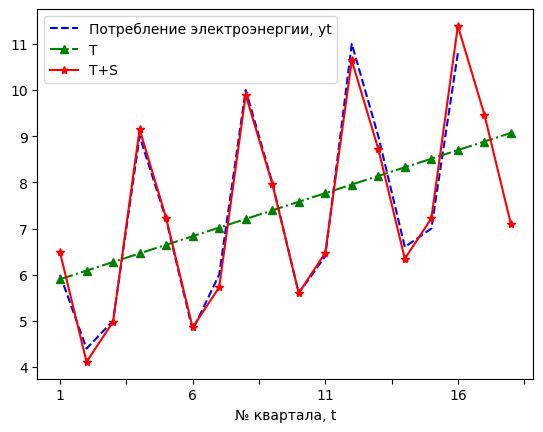

In [13]:
print(f'Таким образом, имеет линейный тренд: '
      f'T = {least_sq_coefs[1]:.2f} + {least_sq_coefs[0]:.3f} * t')
df3[[df3.columns[0],'T','T+S']].iloc[:-2].plot(style=['b--','g^-.','r*-'])

### 5. Предскажем уровни потребления на 17 и 18 кварталы

T для 17 и 18 равна 8,9 и 9,1 соответстенно. S - равна 0,58 и -1,98.  
Тогда предсказанные значения (T + S) равны 9,47 и 7,01. Значения представлены в таблице.

##### Характеристики регрессионной модели были приведены в работе, но не были описаны способы их получения. Поэтому для их вычисления воспользовался пакетом statsmodels

In [14]:
import statsmodels.api as sm
x = sm.add_constant(np.array(list(df3['T+E=Y+S'].iloc[0:16].index.values)))
Y = df3['T+E=Y+S'].iloc[0:16].values
olsmod = sm.OLS(Y, x)
olsres = olsmod.fit()
display(olsres.summary())

C:\Users\Evgen\NeuralNetworks\Lib\site-packages\scipy\stats\_stats_py.py:1736: UserWarning: kurtosistest only valid for n>=20 ... continuing anyway, n=16
  warnings.warn("kurtosistest only valid for n>=20 ... continuing "


<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                      y   R-squared:                       0.915
Model:                            OLS   Adj. R-squared:                  0.909
Method:                 Least Squares   F-statistic:                     150.6
Date:                Sun, 14 Jan 2024   Prob (F-statistic):           7.00e-09
Time:                        17:09:02   Log-Likelihood:                -1.2708
No. Observations:                  16   AIC:                             6.542
Df Residuals:                      14   BIC:                             8.087
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          5.7154      0.147     38.916      0.000       5.400       6.030
x1             0.1864      0.015     12.274      0.000       0.154       0.219
==============================================================================
Omnibus:                        2.215   Durbin-Watson:                   1.286
Prob(Omnibus):                  0.330   Jarque-Bera (JB):                1.311
Skew:                          -0.698   Prob(JB):                        0.519
Kurtosis:                       2.864   Cond. No.                         20.5
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""